### Torch introduction

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [81]:
# Генерация данных
x = torch.linspace(0, 2*np.pi, 1000).reshape(-1, 1)
y = torch.sin(x)

In [ ]:
# Определение архитектуры сети
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 64)  # Входной слой (1 признак -> 64 нейрона)
        self.fc2 = nn.Linear(64, 64)  # Скрытый слой
        self.fc3 = nn.Linear(64, 1)   # Выходной слой
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Создание модели, функции потерь и оптимизатора
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Обучение модели
epochs = 500
losses = []

for epoch in range(epochs):
    # Forward pass
    outputs = model(x)
    loss = criterion(outputs, y)
    
    # Backward pass и оптимизация
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')

Epoch 0, Loss: 0.054249
Epoch 50, Loss: 0.015931
Epoch 100, Loss: 0.004915
Epoch 150, Loss: 0.001908
Epoch 200, Loss: 0.000832
Epoch 250, Loss: 0.000396
Epoch 300, Loss: 0.000234
Epoch 350, Loss: 0.000134
Epoch 400, Loss: 0.000101
Epoch 450, Loss: 0.000096


Text(0, 0.5, 'MSE Loss')

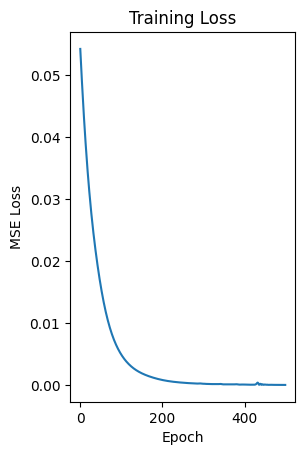

In [84]:
# График потерь
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

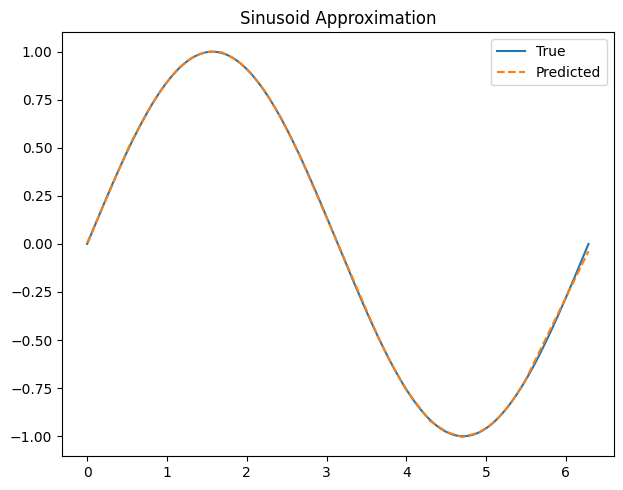

: 

In [ ]:
# Визуализация результатов
plt.figure(figsize=(12, 5))

# График предсказаний
plt.subplot(1, 2, 2)
with torch.no_grad():
    preds = model(x)
plt.plot(x.numpy(), y.numpy(), label='True')
plt.plot(x.numpy(), preds.numpy(), label='Predicted', linestyle='--')
plt.title('Sinusoid Approximation')
plt.legend()

plt.tight_layout()
plt.show()

# Лекция 2: DQN

## Часть 1: Повторение и мотивация

### 1.1 Обзор Q-learning

Алгоритм Q-learning относится к методам обучения с подкреплением, использующим табличное представление функции действия-ценности (action-value function). Цель состоит в том, чтобы аппроксимировать оптимальную функцию $ Q^*(s, a) $, определяемую уравнением Беллмана оптимальности:

$$
Q^*(s, a) = \mathbb{E} \left[ r + \gamma \max_{a'} Q^*(s', a') \mid s, a \right] \approx r + \gamma \max_{a'} Q^*(s', a')
$$

Значение $ Q^*(s, a) $ соответствует ожидаемому дисконтированному суммарному вознаграждению при выборе действия $ a $ в состоянии $ s $, после чего агент следует оптимальной стратегии.

Алгоритм обновляет приближение к $ Q^*(s, a) $ по следующему правилу:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$

где:
- $ \alpha \in (0, 1] $ — скорость обучения (learning rate),
- $ \gamma \in [0, 1] $ — коэффициент дисконтирования,
- $ r $ — полученная награда,
- $ s' $ — следующее состояние после перехода.

### 1.2 Ограничения табличных методов

- **Большое пространство состояний**: при работе с изображениями, сенсорными данными и другими высокоразмерными наблюдениями невозможно хранить таблицу значений.
- **Непрерывные пространства состояний**: невозможность представить все состояния в дискретной форме.

### 1.3 Мотивация перехода к DQN

Для преодоления указанных ограничений используется идея замены таблицы значений нейронной сетью. В Deep Q-Network (DQN) функция $ Q(s, a) $ аппроксимируется с помощью параметрической модели $ Q(s, a; \theta) $, где $ \theta $ — параметры нейросети. Такая модель обучается так, чтобы приближать оптимальную функцию действия-ценности.

Переход от табличного метода к нейросетевой аппроксимации позволяет:

- работать с непрерывными и высокоразмерными пространствами состояний (например, изображениями из игр Atari),
- обеспечивать обобщение между похожими состояниями,
- использовать методы оптимизации нейросетей, такие как стохастический градиентный спуск.

### 1.4 Переход от Q-learning к DQN

В алгоритме **Q-learning** обновление Q-значений для состояния $ s $ и действия $ a $ осуществляется по следующей формуле:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$

Теперь, в **DQN** мы используем нейронную сеть для аппроксимации функции $ Q(s, a) $, поскольку в большинстве сложных задач (например, в играх Atari) пространство состояний и действий очень большое. Формула для обновления в DQN будет аналогична, но с использованием нейросети.

$$
\theta \leftarrow \theta - \alpha \nabla_\theta L(\theta)
$$


#### Целевая функция и функция потерь

Теперь давайте явно выделим **целевую функцию** и **функцию потерь**:

- **Целевая функция** (target) для обновления Q-значений будет вычисляться следующим образом:

$$
y = r + \gamma \max_{a'} Q(s', a'; \theta^-)
$$

Это значение и будет целевой величиной, к которой мы стремимся при обучении нашей нейросети. Она показывает ожидаемое будущее вознаграждение для состояния $ s' $ и действия $ a' $.

- **Функция потерь** (loss function) для DQN определяется как разница между текущими Q-значениями и целевыми значениями. Используем **среднеквадратичную ошибку** (MSE) между предсказанными и целевыми значениями:

$$
L(\theta) = \sum_B \left[ \left( y - Q(s, a; \theta) \right)^2 \right]
$$

Таким образом, в **DQN** обновление параметров сети происходит за счет минимизации функции потерь, где целевая функция (таргет) вычисляется с использованием целевой сети. Это позволяет стабилизировать обучение и избежать проблем с переоценкой Q-значений, которые могут возникать в стандартном Q-learning.

## Часть 2: Архитектура DQN

В Deep Q-Network (DQN) используется нейронная сеть для аппроксимации функции действия-ценности $ Q(s, a; \theta) $. Основная идея заключается в том, чтобы минимизировать расхождение между текущим приближением функции $ Q $ и значением, вычисленным по уравнению Беллмана.

### 2.1 Основные компоненты алгоритма DQN

#### 1. **Q-сеть (Online network)**

Нейронная сеть с параметрами $ \theta $, которая аппроксимирует $ Q(s, a) $. Она используется для выбора действия и для оценки текущей политики агента.

#### 2. **Целевая сеть (Target network)**

Дополнительная сеть с параметрами $ \theta^- $, которая копирует параметры основной Q-сети через фиксированные интервалы. Она используется для вычисления целевых значений при обучении, обеспечивая стабильность.

Обновление параметров целевой сети:
$$
\theta^- \leftarrow \theta \quad \text{(раз в } N_{\text{update}} \text{ шагов)}
$$

#### 3. **Буфер воспроизведения (Replay Buffer)**

Хранит пары $(s, a, r, s', \text{done})$, собранные в ходе взаимодействия агента со средой. Используется для случайного сэмплирования батчей при обучении.

<img src=./assets/replay_buffer.png>

Преимущества:
- Декоррелирует последовательные наблюдения
- Повышает эффективность использования данных

#### 4. **Эпсилон-жадная стратегия выбора действия**

Используется для балансировки исследования и использования знаний:

$$
a = 
\begin{cases}
\text{случайное действие}, & \text{с вероятностью } \varepsilon \\
\arg\max_a Q(s, a; \theta), & \text{с вероятностью } 1 - \varepsilon
\end{cases}
$$

Параметр $ \varepsilon $ обычно убывает с течением времени от $ \varepsilon_{\text{start}} $ до $ \varepsilon_{\text{end}} $, обеспечивая сначала активное исследование, затем — эксплуатацию выученной стратегии.

## Часть 3: Функция потерь и обучение

### 3.1 Обучающая цель DQN

В алгоритме DQN мы хотим минимизировать расхождение между предсказанным значением $ Q(s, a; \theta) $ и целевым значением, вычисленным по уравнению Беллмана. Это можно рассматривать как задачу регрессии с функцией потерь вида:

$$
L(\theta) = \mathbb{E}_{(s, a, r, s') \sim \mathcal{D}} \left[ \left( y - Q(s, a; \theta) \right)^2 \right]
$$

где:
- $ y = r + \gamma \max_{a'} Q(s', a'; \theta^-) $ — целевое значение, вычисляемое с использованием **замороженной целевой сети** с параметрами $ \theta^- $,
- $ \mathcal{D} $ — буфер воспроизведения, из которого берутся случайные мини-батчи.

Обратите внимание, что градиент вычисляется **только по $ \theta $**, параметры целевой сети $ \theta^- $ не обновляются во время одного градиентного шага — они фиксированы и обновляются с задержкой.

### 3.2 Алгоритм обучения DQN

Обучение нейросети осуществляется с использованием стохастического градиентного спуска:

1. Инициализация сети с параметрами $ \theta $ и копии целевой сети $ \theta^- \leftarrow \theta $
2. Повторять для каждого шага взаимодействия:
   - Выбрать действие с использованием $ \varepsilon $-жадной стратегии
   - Выполнить действие в среде, получить $ (s, a, r, s') $
   - Сохранить переход в буфер воспроизведения $ \mathcal{D} $
   - Выбрать случайный мини-батч из $ \mathcal{D} $
   - Вычислить целевое значение:
     $$
     y = 
     \begin{cases}
     r, & \text{если эпизод завершён} \\
     r + \gamma \max_{a'} Q(s', a'; \theta^-), & \text{иначе}
     \end{cases}
     $$
   - Обновить параметры $ \theta $, минимизируя $ (y - Q(s, a; \theta))^2 $
   - Каждые $ N $ шагов обновить параметры целевой сети: $ \theta^- \leftarrow \theta $

### 3.3 Примечание о стабильности

DQN использует два ключевых приёма для обеспечения стабильности:
- **Replay Buffer**: уменьшает корреляцию между обучающими примерами
- **Целевая сеть**: снижает колебания и расхождения в целевых значениях


## Часть 4: Реализация DQN на CartPole

Среда `CartPole-v1` из библиотеки `gymnasium` представляет собой классическую задачу управления маятником на тележке. Цель агента — удерживать маятник в вертикальном положении как можно дольше. Пространство состояний — непрерывное, но небольшое по размерности (4 признака), а действия дискретны (движение тележки влево или вправо).

Это отличная среда для отладки и начального тестирования DQN.


In [ ]:
### 4.1 Установка зависимостей

# !pip install gymnasium torch numpy matplotlib tqdm

In [14]:
### 4.2 Архитектура нейросети

import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

In [15]:
### 4.3 Буфер воспроизведения

import random
from collections import deque, namedtuple

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)


## Часть 5: Обучение DQN-агента на среде CartPole

Теперь, когда у нас есть нейросеть и буфер воспроизведения, давайте реализуем цикл обучения для DQN. Мы будем использовать эпсилон-жадную стратегию для выбора действий и оптимизировать параметры сети с помощью градиентного спуска.


In [30]:
### 5.1 Обучение DQN

import gymnasium as gym
import numpy as np
import torch.optim as optim

# Параметры среды и агента
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Инициализация нейросети, целевой сети и буфера воспроизведения
policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

buffer = ReplayBuffer()
optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)

gamma = 0.99
batch_size = 64
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay = 200
num_episodes = 500

# Эпсилон-жадная стратегия
def select_action(state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # случайное действие
    else:
        with torch.no_grad():
            return policy_net(torch.FloatTensor(state).unsqueeze(0)).argmax(dim=1).item()  # действие с максимальной ценностью

### 5.2 Обновление сети и расчёт лосса

Теперь давайте реализуем обучение агента. Для этого нужно выбрать мини-батч из буфера воспроизведения, вычислить целевые значения, а затем обновить параметры сети с помощью градиентного спуска.

In [24]:
def optimize_model(device="cpu"):
    if len(buffer) < batch_size:
        return

    transitions = buffer.sample(batch_size)
    batch = Transition(*zip(*transitions))

    states = torch.FloatTensor(batch.state).to(device)
    actions = torch.LongTensor(batch.action).to(device)
    rewards = torch.FloatTensor(batch.reward).to(device)
    next_states = torch.FloatTensor(batch.next_state).to(device)
    dones = torch.BoolTensor(batch.done).to(device)

    # Вычисление целевых значений
    state_action_values = policy_net(states).gather(1, actions.unsqueeze(1))
    next_state_values = target_net(next_states).max(1)[0]
    expected_state_action_values = rewards + (gamma * next_state_values * ~dones)

    # Вычисление потерь
    loss = F.mse_loss(state_action_values.squeeze(), expected_state_action_values)

    # Обновление сети
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### 5.3 Основной цикл обучения

Теперь, используя вышеописанные компоненты, мы можем реализовать основной цикл обучения, в котором агент будет взаимодействовать со средой, собирать данные в буфер и обновлять модель.

In [31]:
epsilon = epsilon_start
for episode in range(num_episodes):
    
    state, info = env.reset()
    episode_reward = 0

    for t in range(1000):  # Максимальное количество шагов в эпизоде
        action = select_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        
        # Сохраняем переход в буфер
        buffer.push(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward

        # Обучаем модель
        optimize_model()

        # Обновляем целевую сеть
        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if done:
            break

    # Эпсилон декремент
    epsilon = max(epsilon_end, epsilon - (epsilon_start - epsilon_end) / epsilon_decay)

    # Выводим статистику
    if (episode + 1) % 10 == 0:
        print(f"Episode {episode+1}/{num_episodes}, Reward: {episode_reward}, Epsilon: {epsilon:.2f}")


Episode 10/500, Reward: 27.0, Epsilon: 0.95
Episode 20/500, Reward: 12.0, Epsilon: 0.90
Episode 30/500, Reward: 49.0, Epsilon: 0.86
Episode 40/500, Reward: 21.0, Epsilon: 0.81
Episode 50/500, Reward: 44.0, Epsilon: 0.76
Episode 60/500, Reward: 39.0, Epsilon: 0.71
Episode 70/500, Reward: 16.0, Epsilon: 0.67
Episode 80/500, Reward: 107.0, Epsilon: 0.62
Episode 90/500, Reward: 127.0, Epsilon: 0.57
Episode 100/500, Reward: 52.0, Epsilon: 0.52
Episode 110/500, Reward: 229.0, Epsilon: 0.48
Episode 120/500, Reward: 136.0, Epsilon: 0.43
Episode 130/500, Reward: 285.0, Epsilon: 0.38
Episode 140/500, Reward: 242.0, Epsilon: 0.33
Episode 150/500, Reward: 197.0, Epsilon: 0.29
Episode 160/500, Reward: 191.0, Epsilon: 0.24
Episode 170/500, Reward: 163.0, Epsilon: 0.19
Episode 180/500, Reward: 64.0, Epsilon: 0.14
Episode 190/500, Reward: 147.0, Epsilon: 0.10
Episode 200/500, Reward: 176.0, Epsilon: 0.05
Episode 210/500, Reward: 186.0, Epsilon: 0.05
Episode 220/500, Reward: 166.0, Epsilon: 0.05
Episod

### 5.4 Визуализация прогресса

Мы можем визуализировать прогресс обучения, отображая среду в реальном времени. Для этого можно использовать метод `env.render()` в цикле.

In [32]:
env = gym.make("CartPole-v1", render_mode="human")

# После завершения обучения отобразим результаты:
sum_reward = 0
for _ in range(1):  # Запускаем несколько тестовых эпизодов

    state, info = env.reset()
    for t in range(1000):
        action = select_action(state, epsilon=0.05)  # Тестируем на минимальном эпсилон
        # action = env.action_space.sample()
        next_state, reward, done, _, _ = env.step(action)

        sum_reward += reward
        state = next_state
        env.render()  # Отображаем кадры среды

        if done:
            break

env.close()

print(f"sum reward: {sum_reward}")

sum reward: 464.0


Теперь, когда мы обучили DQN-агента на среде `CartPole`, можно будет использовать аналогичный подход для более сложных сред, например, игры Atari. Если всё понятно, можем продолжить с **разбором Atari** и применением DQN к играм.

## Часть 6: Применение DQN к играм Atari


Игры Atari из библиотеки `gymnasium` предоставляют более сложные задачи для обучения, чем среда `CartPole`, благодаря большему количеству состояний и действий, а также использованию изображений в качестве входных данных.

### 6.1 Среда Atari

Мы будем использовать классическую среду Atari `PongNoFrameskip-v4`, которая является одной из популярных среди исследований в области обучения с подкреплением. В этой среде агент управляет ракеткой в игре Pong, пытаясь отбить мяч и не дать ему пройти через ворота.

Игры Atari имеют несколько особенностей:
- **Изображения**: Состояния представлены в виде изображений (RGB картинки 210x160).
- **Дискретные действия**: Агент может выбрать одно из нескольких действий, например, двигаться вверх, вниз или не двигаться.
- **Преобразование изображений**: Для того чтобы нейросеть могла работать с изображениями, их часто нужно преобразовать (например, преобразовать в оттенки серого и уменьшить разрешение).


### 6.2 Установка зависимостей

Если у вас ещё не установлены зависимости, то установите их с помощью:

In [ ]:
# !pip install gymnasium[atari] torch numpy matplotlib opencv-python

### 6.3 Преобразование изображений

Для работы с изображениями в DQN часто используют несколько техник, включая преобразование в оттенки серого, уменьшение разрешения и нормализацию. Важно преобразовывать изображения так, чтобы они подходили для подачи на нейросеть.

In [5]:
import cv2

def preprocess_observation(observation):
    # Преобразуем изображение в оттенки серого и уменьшаем разрешение
    gray_image = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
    resized_image = cv2.resize(gray_image, (84, 84))  # Стандартный размер для DQN
    return np.expand_dims(resized_image, axis=0)  # Добавляем размерность для батча

### 6.4 Реализация DQN для Atari

Для игры в Atari мы будем использовать аналогичную нейросеть, но входные данные будут иметь размерность $ 84 \times 84 $, а на выходе мы будем предсказывать Q-значения для каждого возможного действия. Чтобы повысить стабильность, мы будем использовать принципиально ту же структуру, как и для `CartPole`, но с дополнительным шагом по подготовке данных.

<img src=./assets/nn_atari.png>

In [50]:
# Архитектура нейросети для игры Atari
class DQNAtari(nn.Module):
    def __init__(self, action_dim):
        super(DQNAtari, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(7*7*64, 512)
        self.out = nn.Linear(512, action_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        return self.out(x)

### 6.5 Обучение на Atari

Теперь можно настроить обучение DQN на Atari. Мы будем использовать те же принципы, что и для `CartPole`, но теперь входные данные будут изображениями, и агент будет обучаться на более сложных задачах.

In [66]:
import ale_py
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing


env = gym.make("PongNoFrameskip-v4")
env = AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, scale_obs=False)

In [68]:
env.observation_space

Box(0, 255, (84, 84), uint8)

In [ ]:

env = gym.make('PongNoFrameskip-v4')
state_dim = (84, 84)  # Размер изображений
action_dim = env.action_space.n

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

# Инициализация нейросетей, целевой сети и буфера воспроизведения
policy_net = DQNAtari(action_dim).to(device)
target_net = DQNAtari(action_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

buffer = ReplayBuffer()
optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
gamma = 0.99
batch_size = 32
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 50000
num_episodes = 100

# Эпсилон-жадная стратегия
def select_action(state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # случайное действие
    else:
        with torch.no_grad():
            return policy_net(torch.FloatTensor(state).unsqueeze(0)).argmax(dim=1).item()

cuda:0


In [ ]:
# Основной цикл обучения
epsilon = epsilon_start
for episode in range(num_episodes):
    state, _ = env.reset()
    state = preprocess_observation(state)
    episode_reward = 0

    for t in range(100):  # Максимальное количество шагов в эпизоде
        action = select_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        next_state = preprocess_observation(next_state)
        
        # Сохраняем переход в буфер
        buffer.push(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward

        # Обучаем модель
        optimize_model(device)

        # Обновляем целевую сеть
        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if done:
            break

    epsilon = max(epsilon_end, epsilon - (epsilon_start - epsilon_end) / epsilon_decay)

    print(f"Episode {episode+1}/{num_episodes}, Reward: {episode_reward}, Epsilon: {epsilon:.2f}")


Теперь у вас есть полный код для обучения DQN на игре Atari, используя `PongNoFrameskip-v4`. Как только агент обучится, можно будет визуализировать его поведение и протестировать на нескольких эпизодах.


In [73]:
env = gym.make('PongNoFrameskip-v4', render_mode="human")
# env = AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, scale_obs=False)
policy_net = policy_net.to("cpu")

# После завершения обучения отобразим результаты:
sum_reward = 0
for _ in range(1):  # Запускаем несколько тестовых эпизодов
    state, info = env.reset()
    for t in range(1000):
        state = preprocess_observation(state)
        action = select_action(state, epsilon=0.05)  # Тестируем на минимальном эпсилон
        next_state, reward, done, _, _ = env.step(action)
        sum_reward += reward
        state = next_state
        env.render()  # Отображаем кадры среды
        if done:
            break

env.close()

print(f"sum reward: {sum_reward}")

sum reward: -6.0


## Часть 7: Улучшения DQN и дополнительные техники

На данном этапе мы уже обучили базовую модель DQN для игры Atari. Однако, как и в любом сложном алгоритме, есть способы улучшить производительность и ускорить обучение. В этой части мы рассмотрим несколько улучшений, которые часто применяются в DQN.

### 7.1. Опытный буфер с приоритетами (Prioritized Experience Replay)

В стандартном DQN используется случайный опытный буфер, но это не всегда эффективно, поскольку некоторые переходы могут быть более важными для обучения, чем другие. Чтобы улучшить качество обучения, мы можем использовать **приоритетный опытный буфер**.

В этом буфере каждый переход имеет приоритет, основанный на величине ошибки предсказания. Приоритетные переходы имеют больше шансов быть повторно выбраны в обучении.

Для реализации приоритетного буфера используем `sumtree` или подход, подобный нему, где переходы с большим TD-ошибкой имеют более высокие приоритеты.

### 7.2. Целевая сеть (Target Network)

В оригинальном DQN используется целевая сеть для вычисления Q-значений на следующих состояниях. Эта сеть обновляется не так часто, как основная сеть, что помогает избежать нестабильности. Мы уже использовали этот механизм, и он помогает в обучении.

Однако для повышения стабильности можно использовать **мягкое обновление целевой сети** (soft target update), что означает, что обновление параметров целевой сети происходит плавно через некоторую форму смешивания, например:

$$
\theta_{\text{target}} \leftarrow \tau \theta_{\text{policy}} + (1 - \tau) \theta_{\text{target}}
$$

где $\tau$ — это коэффициент, контролирующий скорость обновления.

### 7.3. Double DQN

Один из известных проблем DQN — это **переоценка Q-значений**. Для устранения этого эффекта был предложен алгоритм **Double DQN**. В Double DQN используется основная сеть для выбора действия, но целевая сеть используется только для расчета Q-значений на следующих состояниях.

Обновленное уравнение для расчета целевого значения будет:

$$
y = r + \gamma Q_{\text{target}}(s', \arg\max_{a} Q_{\text{policy}}(s', a; \theta); \theta^-)
$$

где $\arg\max_{a} Q_{\text{policy}}(s', a; \theta)$ выбирает действие, используя основную сеть, а $\theta^-$ — параметры целевой сети.

### 7.4. Dueling DQN

Другая улучшенная версия DQN — это **Dueling DQN**, в которой разделяются две части нейросети: одна для оценки ценности состояния (V) и другая для оценки действия (A). Это помогает улучшить обучение в средах, где состояние имеет большую важность, чем конкретные действия.

Уравнение для Q-значений в Dueling DQN будет следующим:

$$
Q(s, a; \theta) = V(s; \theta) + (A(s, a; \theta) - \max_{a'} A(s, a'; \theta))
$$

где:
- $V(s; \theta)$ — оценка ценности состояния,
- $A(s, a; \theta)$ — оценка преимущества действия.

### 7.5. Нормализация градиентов (Gradient Clipping)

Для более стабильного обучения можно использовать технику **нормализации градиентов** (или клиппинг градиентов), что помогает избежать скачков градиентов и улучшить сходимость. Это особенно полезно в нейросетях, где параметры могут сильно изменяться.

Пример:

```python
torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
```

### 7.6. Вывод и тестирование модели

После успешного обучения важно протестировать агента на несколько эпизодов, чтобы удостовериться в том, что агент научился выполнять задачу.

In [35]:
# Тестирование обученного агента
for _ in range(5):
    state, _ = env.reset()
    state = preprocess_observation(state)
    total_reward = 0
    for t in range(1000):
        state = np.transpose(state, (2, 0, 1)).unsqueeze(0)
        action = select_action(state, epsilon=0.05)  # Применяем минимальный эпсилон
        next_state, reward, done, _, _ = env.step(action)
        next_state = preprocess_observation(next_state)
        total_reward += reward
        state = next_state
        env.render()
        if done:
            break
    print(f"Total reward: {total_reward}")
env.close()

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

## Заключение

В этом занятии мы рассмотрели:
1. Основы DQN и его использование на простых средах (например, CartPole).
2. Применение DQN для более сложных задач, таких как игры Atari.
3. Улучшения DQN, такие как приоритетный опытный буфер, Double DQN, Dueling DQN и другие методы для повышения стабильности и производительности.

В результате студентам будет понятно, как применять DQN к различным средам, как улучшать алгоритм и какие техники могут быть использованы для достижения лучших результатов.